In [4]:
import polars as pl
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
import json

sns.set_style("darkgrid")

RAW_DATA_FILE = 'Movies_and_TV_5.json'
NETWORK_FILE = "movie_network.json"

[Get dataset here](https://nijianmo.github.io/amazon/index.html)

In [2]:
def save_graph(graph_file, G):
    data = nx.readwrite.json_graph.node_link_data(G)
    with open(graph_file, "w") as f:
        json.dump(data, f)

def load_graph(graph_file):
    with open(graph_file, "r") as f:
        data = json.load(f)
    return nx.readwrite.json_graph.node_link_graph(data)

### Filtering

In [32]:
df = pl.scan_ndjson('Movies_and_TV.jsonl').filter(pl.col('verified_purchase') == True).filter(pl.col('helpful_vote') != 0)
existing = set(df.collect_schema().keys())
drop_cols = {'images', 'style', 'verified_purchase', 'asin', 'helpful_vote', 'title'} 
keep_cols = list(existing - drop_cols)
df = df.select(keep_cols).rename({'parent_asin': 'asin'})

In [33]:
df.limit(100).collect()

rating,asin,user_id,timestamp,text
f64,str,str,i64,str
5.0,"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""",1146713492000,"""This DVD was GREAT! I am a st…"
3.0,"""B000PIU2A0""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1556496429981,"""this item was canceled. . . .n…"
5.0,"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088518000,"""I grew up with this one. could…"
4.0,"""B000TSMOEI""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088147000,"""like watching: haven't gotten …"
4.0,"""B0009MAO82""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364087577000,"""pretty cool to watch: differen…"
…,…,…,…,…
5.0,"""B01N7K1IUQ""","""AFZUK3MTBIBEDQOPAK3OATUOUKLA""",1498366665692,"""I watched an &#34;edited&#34; …"
4.0,"""B00906FN2K""","""AFZUK3MTBIBEDQOPAK3OATUOUKLA""",1489165456000,"""I just joined Weight Watchers …"
5.0,"""B01DX663IK""","""AFZUK3MTBIBEDQOPAK3OATUOUKLA""",1479621835000,"""While this is hard to watch...…"


In [ ]:
df.collect().height, df.collect().get_column("asin").n_unique()

(2888210, 409673)

In [37]:
def filter_reviews(df, movie_threshold=5, review_threshold=5):
    df = df.collect()
    prev_rows = -1
    while df.height != prev_rows:
        prev_rows = df.height
        valid_movies = (
            df.group_by('asin')
            .agg(pl.col('user_id').n_unique().alias('count'))
            .filter(pl.col('count') >= review_threshold)
            .get_column('asin')
        )
        df = df.filter(pl.col('asin').is_in(valid_movies.implode()))

        valid_reviewers = (
            df.group_by('user_id')
            .agg(pl.col('asin').n_unique().alias('count'))
            .filter(pl.col('count') >= movie_threshold)
            .get_column('user_id')
        )
        df = df.filter(pl.col('user_id').is_in(valid_reviewers.implode()))
    return df

filtered_df = filter_reviews(df)

In [38]:
reviewer_counts = (
    df.group_by('user_id')
    .agg(pl.col('asin').n_unique().alias('count'))
    .filter(pl.col('count') > 500).collect()
)
reviewer_counts_count = reviewer_counts.height
reviewer_counts_count

9

In [39]:
filtered_df.get_column("asin").n_unique()

28569

### Network

In [40]:
def generate_edge_list():
    grouped = (
        filtered_df
        .group_by('user_id')
        .agg(pl.col('asin').unique().alias('asins'))
    )

    edges = Counter()

    for reviewers in tqdm(grouped['asins'], desc="Reviewer"):
        for pair in combinations(reviewers, 2):
            edges[tuple(sorted(pair))] += 1

    return [(a, b, count) for (a, b), count in edges.items()]

In [41]:
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer: 100%|██████████| 29578/29578 [00:02<00:00, 12350.33it/s]


3380500

In [48]:
thresholds = [4,5,7,10,15]
for t in thresholds:
    weighted_edges = [(a, b, w) for (a, b, w) in movie_edgelist if w >= t]
    print(f"Edges with weight => {t}: {len(weighted_edges)}")

Edges with weight => 4: 6344
Edges with weight => 5: 3276
Edges with weight => 7: 1288
Edges with weight => 10: 493
Edges with weight => 15: 150


### Graph

In [47]:
WEIGHT_THRESHOLD = 2
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

115364

In [49]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_movie_edge)
save_graph(NETWORK_FILE, G)

c:\Users\rdh\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [54]:
len(G.nodes()), len(G.edges())

(21586, 115364)

In [56]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

10.68877976466228

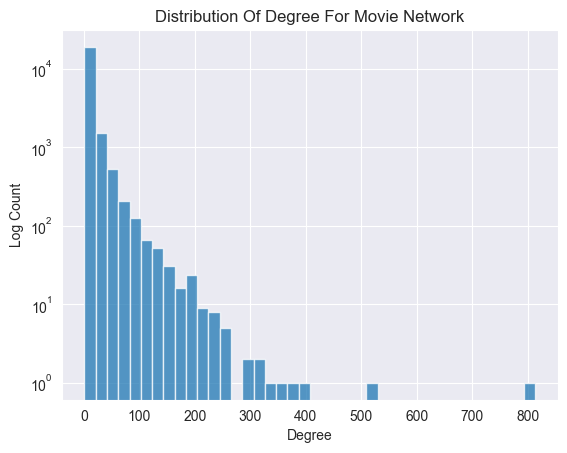

In [57]:
X = list(dict(G.degree).values())
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 40, alpha=0.75);

### Community detection

In [59]:
def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [60]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [61]:
communities = louvain_partitions(G)
len(communities)

363

In [53]:
modularity(G, communities) 

0.7512698606438895

### Text analysis